- 오늘날의 딥러닝은 엄청난 데이터와의 싸움!
  - DSWP < CETI < BERT < GPT-2 < GPT-3

## 개념 정리
- Single vs Multi
  - GPU를 한개쓸지 여러개 쓸지
- GPU vs Node
  - Node: 한대의 컴퓨터
- Single Node Single GPU
  - 한대의 컴퓨터의 한개의 GPU
- Single Node Multi GPU
  - 한대의 컴퓨터의 여러개의 GPU(4~8개)
- Multi Node Multi GPU (추구하는 방향)
  - 여러 대의 컴퓨터의 여러개의 GPU

## Multi GPU 두가지 학습 방법
### Model parallel (모델 병렬화)
- 다중 gpu에 학습을 분산하는 두가지 방법
  - 모델 나누기 / 데이터 나누기
- alexnet부터 모델 나누기 해왔음
- 모델의 병목, 파이프라인의 어려움 등으로 인해 모델 병렬화는 고난이도 과제
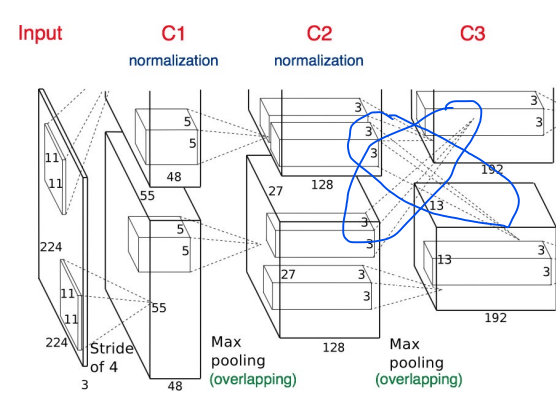
  - 교차되는 부분이 모델 병렬화를 위함

- 중요한 이슈: 파이프라인 만들기,배치가 많이 겹칠수록 좋은 모델 병렬화
  - 위에는 안 좋은 예, 아래는 좋은 예
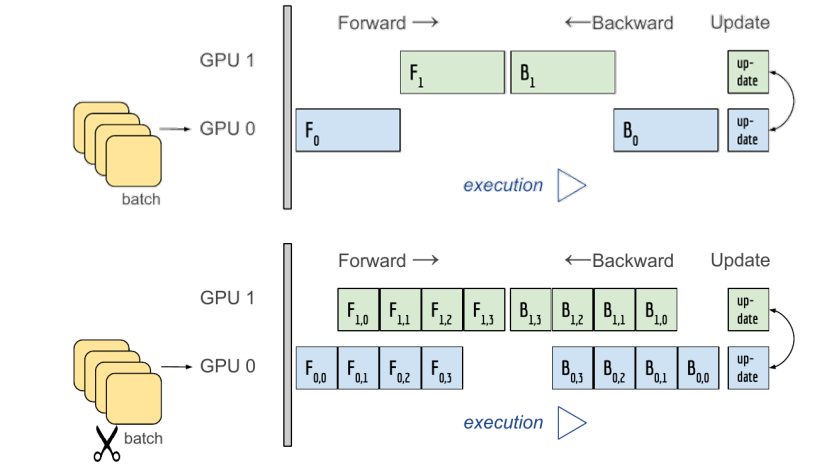

In [ ]:
class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes=num_classes, *args, **kwargs)
        
        # 첫번째 모델을 cuda 0에 할당
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,

            self.layer1,
            self.layer2
        ).to('cuda:0')

        # 두번째 모델을 cuda 0에 할당
        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to('cuda:1')

        self.fc.to('cuda:1')

    # 두 모델을 연결하기
    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

### Data parallel (데이터 병렬화)
- 데이터를 gpu에 할당후 결과의 평균을 취함
- minibatch 수식과 유사한데 한번에 여러 gpu에서 수행
  - ex.GPU1~4에서 각각 forward pass 연산
  - 연산한 값을 GPU1에 모아줌 [1,2,3,4]
  - GPU1에서 loss gradient 값을 구해줌
  - 다시 GPU1~4로 gradient 분산시킴
  - 각각 backward pass 연산
  - 연산값 다시 GPU1에 모아줌
- Pytorch에서는 두가지 방식 제공
  - data parallel: 단순히 데이터 분배하고 평균을 취함
  → GPU 사용 불균형 문제, Batch 사이즈 감소, GIL
  - DistributedDataParallel: 각 CPU마다 프로세스 생성하여 개별 GPU에 할당
    → 개별적으로 연산 평균 냄

In [ ]:
#DataParallel
parallel_model=torch.nn.DataParallel(model)

predictions=parallel_model(inputs)
loss=loss_function(predictions,labels) # loss 계산
loss.mean().backward() 
optimizer.step()
predictions=parallel_model(inputs)

In [ ]:
#DistributedDataParallel
train_sampler=torch.utils.data.distributed.DistributedSampler(train_data)#sampler 사용
shuffle=False
pin_memory=True
trainloader=torch.utils.data.DataLoader(train_data,batch_size=20,shuffle=False,
                                        pin_memory=pin_memory,num_workers=3,
                                        shuffle=shuffle,sampler=train_sampler)


In [ ]:
 from multiprocessing import Pool
def main():
  n_gpus = torch.cuda.device_count()
  #n_gpus=gpu 개수
  torch.multiprocessing.spawn(main_worker, nprocs=n_gpus, args=(n_gpus, ))

def main_worker(gpu, n_gpus):
  image_size = 224
  batch_size = 512
  num_worker = 8
  epochs = ...
  # gpu 개수만큼 나누기
  batch_size = int(batch_size / n_gpus)
  num_worker = int(num_worker / n_gpus)
  #멀티프로세싱 통신 규약 정의
  torch.distributed.init_process_group(backend='nccl',
                                      init_method='tcp://127.0.0.1:2568',
                                      world_size=n_gpus, rank=gpu)
  model = MODEL
  # Distributed Dataparallel 정의
  torch.cuda.set_device(gpu) model = model.cuda(g
  pu)
  model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])

#Python의 멀티프로세싱 코드
def f(x):
  return x*x

if __name__ == '__main ':
  with Pool(5) as p:
    print(p.map(f, [1, 2, 3]))

## 회고
- multi gpu의 두가지 학습방법에 대해서 알아보았다. 그중에서도 데이터 병렬 방법 중 하나인 distributed data parallel 방법이 중요한 것 같다. 지금 당장은 사용하지 않아도 후에 꼭 실습해보면 좋다고 하셨으니, 나중에 네이버 클라우드를 사용할 수 있을 때 한 번 이 방법을 사용해 봐야겠다.